# Train model for upload to Kaggle

## Notebook set up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

# Silence tensorflow, except for errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Run on the GTX1080 GPU - fastest single worker/small memory performance
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_project_root()

# Standard library imports
import pickle
import time
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Local imports
from ariel_data_preprocessing.data_preprocessing import DataProcessor
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/model_training'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

# Make sure models directory exists
Path(f'{config.MODELS_DIRECTORY}/kaggle').mkdir(parents=True, exist_ok=True)

# Best settings from ~400 Optuna optimization trials
# (see model_training/optimize_cnn.py)
sample_size = 372
batch_size = 4
steps = 431
learning_rate = 0.0007103203515277739
l_one = 0.9381346432258663
l_two = 0.36282682418942663
cnn_layers = 3
first_filter_set = 73
second_filter_set = 34
third_filter_set = 48
first_filter_size = 2
second_filter_size = 5
third_filter_size = 3
dense_units = 104
beta_one=0.72
beta_two=0.93
amsgrad=True
weight_decay=0.016
use_ema=True

# Long training run
epochs = 10
samples = 10

total_ksteps = int((epochs * steps) / 1000)
model_save_file = f'{config.MODELS_DIRECTORY}/kaggle/ariel_cnn-8.4M-{total_ksteps}ksteps.keras'
training_results_save_file = f'{config.MODELS_DIRECTORY}/kaggle/ariel_cnn-8.4M-{total_ksteps}ksteps.pkl'

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Initialize data generators

In [2]:
data_preprocessor = DataProcessor(
    input_data_path=config.RAW_DATA_DIRECTORY,
    output_data_path=config.PROCESSED_DATA_DIRECTORY,
    mode='train',
)

data_preprocessor.initialize_data_generators(
    sample_size=sample_size,
    validation=False
)

## 2. Model definition

In [3]:
def compile_model(
        samples: int=sample_size,
        wavelengths: int=config.WAVELENGTHS,
        learning_rate: float=learning_rate,
        l1: float=l_one,
        l2: float=l_two,
        first_filter_set: int=first_filter_set,
        second_filter_set: int=second_filter_set,
        third_filter_set: int=third_filter_set,
        first_filter_size: int=first_filter_size,
        second_filter_size: int=second_filter_size,
        third_filter_size: int=third_filter_size,
        dense_units: int=dense_units,
        beta_one: float=beta_one,
        beta_two: float=beta_two,
        amsgrad: bool=amsgrad,
        weight_decay: float=weight_decay,
        use_ema: bool=use_ema
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((samples,wavelengths,1)),
        tf.keras.layers.Conv2D(
            first_filter_set,
            first_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            second_filter_set,
            second_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            third_filter_set,
            third_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            dense_units,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='linear')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_one,
        beta_2=beta_two,
        amsgrad=amsgrad,
        weight_decay=weight_decay,
        use_ema=use_ema
    )

    # Compile the model, specifying the type of loss to use during training 
    # and any extra metrics to evaluate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='RMSE')
        ]
    )

    return model

In [4]:
model = compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 372, 283, 73)      365       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 186, 141, 73)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 186, 141, 34)      62084     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 93, 70, 34)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 93, 70, 48)        14736     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 35, 48)       0

## 3. Training run

In [5]:
if Path(model_save_file).exists() and Path(training_results_save_file).exists():

    print(f'Found existing model for {total_ksteps} ksteps, skipping training.')

    # Load the existing model
    model = tf.keras.models.load_model(model_save_file)

    # Load existing training results
    with open(training_results_save_file, 'rb') as input_file:
        training_results = pickle.load(input_file)

else:

  print(f'Training model for {total_ksteps} ksteps')
  start_time = time.time()

  training_results = model.fit(
    data_preprocessor.training.batch(batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1
  )

  print(f'Training complete in {(time.time() - start_time)/60:.1f} minutes')
  model.save(model_save_file)

  with open(training_results_save_file, 'wb') as output_file:
      pickle.dump(training_results, output_file)

Found existing model for 4 ksteps, skipping training.
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2025-09-21 19:18:58           64
variables.h5                                   2025-09-21 19:18:58    162929160
config.json                                    2025-09-21 19:18:58         4555
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......root_mean_squared_error
.........vars


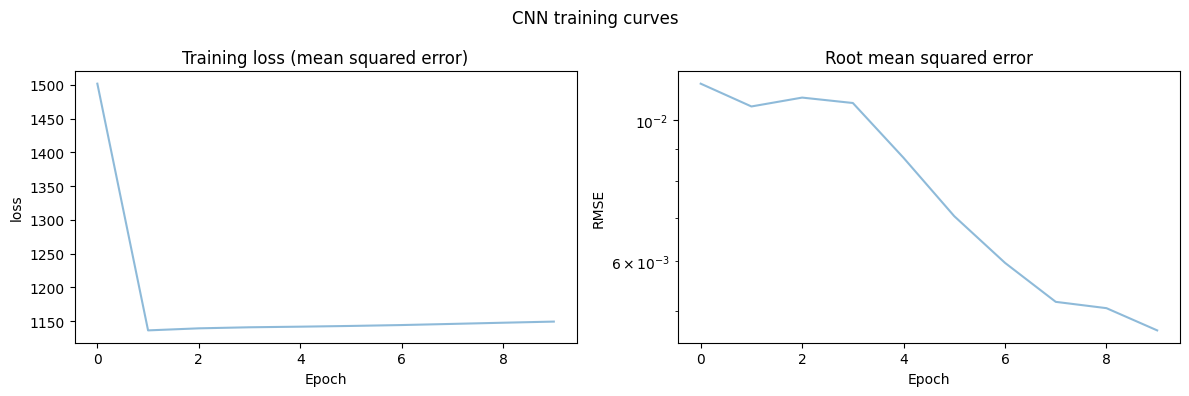

In [6]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(12,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training loss
axs[0].set_title('Training loss (mean squared error)')
axs[0].plot(np.array(training_results.history['loss']), alpha=0.5, label='Training')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('loss')
# axs[0].set_ylim(21, 25)
# axs[0].set_yscale('log')

# Plot training RMSE
axs[1].set_title('Root mean squared error')
axs[1].plot(training_results.history['RMSE'], alpha=0.5, label='Training')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('RMSE')
# axs[2].set_ylim(top=0.014)
axs[1].set_yscale('log')

# Show the plot
fig.tight_layout()
fig.savefig(
    f'{figures_dir}/03.4.1-ariel_cnn_kaggle_test_training_curves_8.4M-{total_ksteps}ksteps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)